# Training the SPOCK model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

Start by loading the training data generated with generate_FC_data.ipynb

In [2]:
#load datapath for clean training data that is generated
datapath = '../../cleanData/csvs/resonant/'

dataset = pd.read_csv(datapath+'23-02-25-thetaSTD.csv')
#remove junk columns
dataset = dataset.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

We can then split the data into training and testing sets, note, we will remove systems that go unstable in 1e4 orbits from the testing set

In [3]:
def train_test(dataset,features):
    '''divides the dataset into 80% training and 20% testing and returns training/testing sets'''
    Nrows = int(0.8*dataset.shape[0])
    train = dataset.iloc[:Nrows, :]
    test = dataset.iloc[Nrows:, :]
    #remove testing systems that go unstable in short integration phase

    test = test.drop(test[test['InitialStable']==False].index)
    return train[features], train['Stable'], test[features], test['Stable'], test['instability_time']

We can then define the features of interest and dividing training and testing sets

In [4]:
dataset.columns

Index(['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear',
       'EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar',
       'threeBRfillfac', 'threeBRfillstd', 'MEGNO', 'MEGNOstd', 'ThetaSTD12',
       'ThetaSTD23', 'ThetaSTD12alt', 'ThetaSTD23alt', 'Tsec', 'near',
       'nearThetaSTD', 'nearThetaSTDalt', 'InitialStable', 'runstring',
       'instability_time', 'shadow_instability_time', 'Stable'],
      dtype='object')

In [5]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno + ['Tsec', 'ThetaSTD12','ThetaSTD23','nearThetaSTD', 'threeBRfillfac']

trainX, trainY, testX, testY, testInstability = train_test(dataset, features)
dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

# Tuning hyperparameter
We will start by creating and testing a collection of models that have randomly selected hyperparameters.
We establish the different parameter space that we will be testing different hyperparameter values within.

In [12]:
space ={'max_depth': hp.qloguniform('x_max_depth', np.log(5), np.log(40), 1),
        'min_child_weight': hp.loguniform('x_min_child', 0, np.log(30)),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
}

def objective(params):
    clf = XGBClassifier(n_estimators = 50,
                            max_depth = int(params['max_depth']), 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            learning_rate = 0.15, seed = 0,)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}


We can now run an array of different parameter combinations

In [13]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 100, trials = trials, rstate=np.random.default_rng(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

SCORE:                                                 
0.9370574252824306                                     
ERROR                                                  
0.0028729872913138732                                  
SCORE:                                                                            
0.9373272858164368                                                                
ERROR                                                                             
0.0029165532274631435                                                             
SCORE:                                                                            
0.9413215277431177                                                                
ERROR                                                                             
0.0030361278076067003                                                             
SCORE:                                                                             
0.9402405721794065          

KeyboardInterrupt: 

We can not determine what values for hyperparameters will be ideal. We can do this by plotting how AUC changes as we alter each hyperparameter.

# max_depth: depth of model trees

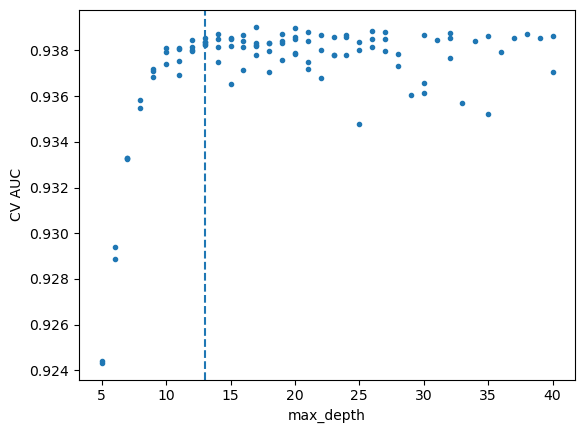

In [ ]:
depths = trials.vals['x_max_depth']
min_childs = trials.vals['x_min_child']
aucs = np.array([1-x['loss'] for x in trials.results])
fig, ax = plt.subplots()
ax.plot(depths, aucs, '.')
ax.set_xlabel('max_depth')
ax.set_ylabel('CV AUC')
ax.axvline(13, linestyle='--')

# min_child_weight: regulates model mitigating complexity 

Text(0, 0.5, 'CV AUC')

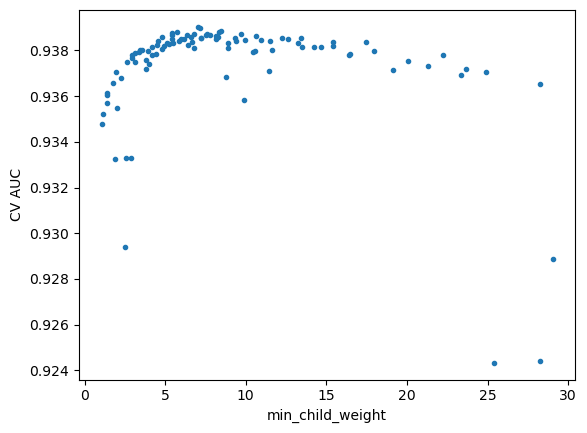

In [ ]:
fig, ax = plt.subplots()
ax.plot(min_childs, aucs, '.')
ax.set_xlabel('min_child_weight')
ax.set_ylabel('CV AUC')

Text(0, 0.5, 'min_child_weight')

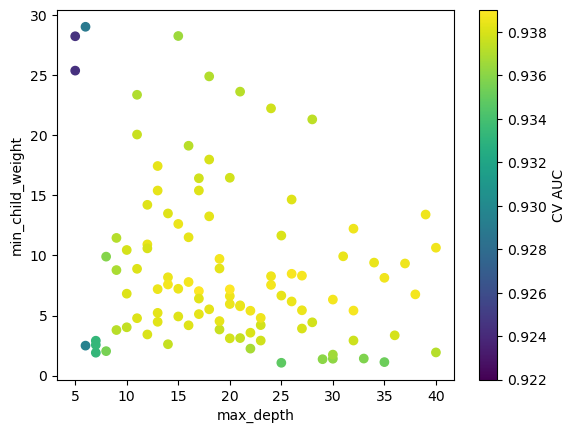

In [ ]:
fig, ax = plt.subplots()
cb = ax.scatter(depths, min_childs, c=aucs, vmin=0.922, vmax=0.939)
plt.colorbar(cb, label='CV AUC')
ax.set_xlabel('max_depth')
ax.set_ylabel('min_child_weight')

# max_depth =13, min_child_weight = 5

Minimum improvement when considering max depth or min child weight larger then 13 and 5 respectively.

In [ ]:
model = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 13, 
                         subsample = 0.95,
                         min_child_weight = 5)

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=400)


[0]	train-auc:0.95011+0.00083	test-auc:0.92233+0.00274
[1]	train-auc:0.95866+0.00052	test-auc:0.93019+0.00376
[2]	train-auc:0.96211+0.00042	test-auc:0.93435+0.00334
[3]	train-auc:0.96407+0.00064	test-auc:0.93623+0.00267
[4]	train-auc:0.96582+0.00054	test-auc:0.93780+0.00285
[5]	train-auc:0.96697+0.00051	test-auc:0.93873+0.00282
[6]	train-auc:0.96797+0.00044	test-auc:0.93963+0.00276
[7]	train-auc:0.96879+0.00031	test-auc:0.93994+0.00268
[8]	train-auc:0.96960+0.00030	test-auc:0.94052+0.00263
[9]	train-auc:0.97029+0.00029	test-auc:0.94091+0.00272
[10]	train-auc:0.97101+0.00028	test-auc:0.94135+0.00266
[11]	train-auc:0.97160+0.00030	test-auc:0.94175+0.00263
[12]	train-auc:0.97220+0.00031	test-auc:0.94214+0.00265
[13]	train-auc:0.97280+0.00027	test-auc:0.94255+0.00268
[14]	train-auc:0.97333+0.00031	test-auc:0.94294+0.00263
[15]	train-auc:0.97385+0.00034	test-auc:0.94326+0.00261
[16]	train-auc:0.97439+0.00035	test-auc:0.94355+0.00260
[17]	train-auc:0.97490+0.00037	test-auc:0.94381+0.00255
[1

# n_estimators (number of trees) tuning

Text(0, 0.5, 'CV AUC score')

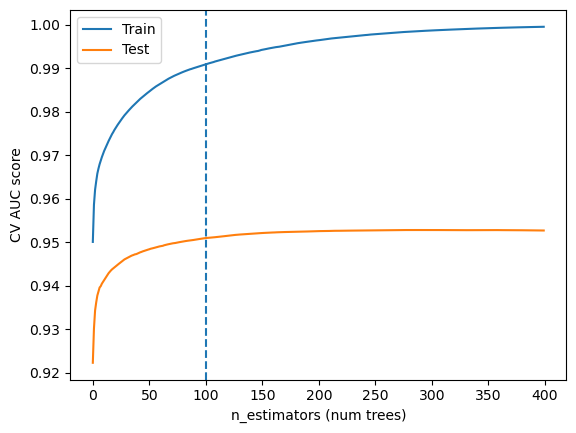

In [ ]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-auc-mean'], label='Train')
ax.plot(score.index, score['test-auc-mean'], label='Test')
ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Minimal improvement in testing AUC after 100 n_estimators

In [ ]:
model.set_params(n_estimators = n_estimators)
model.fit(trainX, trainY)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
model.save_model('../spock/models/featureclassifier.json')

In [ ]:
model = XGBClassifier()
model.load_model('../spock/models/featureclassifier.json')

# SPOCK feature classifier evaluation

In [6]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno + ['Tsec', 'ThetaSTD12','ThetaSTD23','nearThetaSTD', 'threeBRfillfac']

trainX, trainY, testX, testY, testInstability = train_test(dataset, features)

In [12]:
model = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 200,
                         )
model.fit(trainX,trainY)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

**Define plotting helper functions**

In [13]:
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, auc
def ROC_curve( model, x,y):
    preds = model.predict_proba(x)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = metrics.roc_auc_score(y, preds)
    return roc_auc, fpr, tpr, ROCthresholds
def stable_unstable_hist(model, testX, testy):
    preds = model.predict_proba(testX)[:,1]
    stablepreds = preds[np.where(testy==1)]
    unstablepreds = preds[np.where(testy==0)]
    return stablepreds, unstablepreds 

def calibration_plot(model, testX, testy, bins):
    
    preds = model.predict_proba(testX)[:,1]

    hist, edges = np.histogram(preds, bins=bins)

    bincenters = []
    fracstable = []
    errorbars = []
    for i in range(len(edges)-1):
        bincenters.append((edges[i]+edges[i+1])/2)
        mask = (preds >= edges[i]) & (preds < edges[i+1])
        nstable = testy[mask].sum()
        fracstable.append(nstable/hist[i]) # fraction of stable systems in bin with predictions in range
        errorbars.append(np.sqrt(1./nstable + 1./hist[i])*fracstable[-1]) # assume poisson counting errors for each fractional error, and add in quadrature for error on ratio. 
        # multiply the fractional error by value

    return np.array(bincenters), np.array(fracstable), np.array(errorbars)

def unstable_error_fraction(model, testX, testY, inst_times, thresh, bins=10, filter=False, filtertimes=False):
    preds = model.predict_proba(testX)[:,1]
    log_inst_times = np.log10(inst_times)
    
    unstable = log_inst_times < 8.99
    preds = preds[unstable]
    log_inst_times = log_inst_times[unstable]

    hist, edges = np.histogram(log_inst_times, bins=bins)

    bincenters = []
    errorfracs = []
    errorbars = []
    for i in range(len(edges)-1):
        bincenters.append((edges[i]+edges[i+1])/2)
        mask = (log_inst_times >= edges[i]) & (log_inst_times < edges[i+1])
        Nerrors = (preds[mask] > thresh).sum()
        errorfracs.append(Nerrors/hist[i])
        errorbars.append(np.sqrt(1./Nerrors + 1./hist[i])*errorfracs[-1]) # see calibration plot comment

    return np.array(bincenters), np.array(errorfracs), np.array(errorbars)

# AUC and FPR

Text(0.5, 1.0, 'ROC curve (AUC = 0.957)')

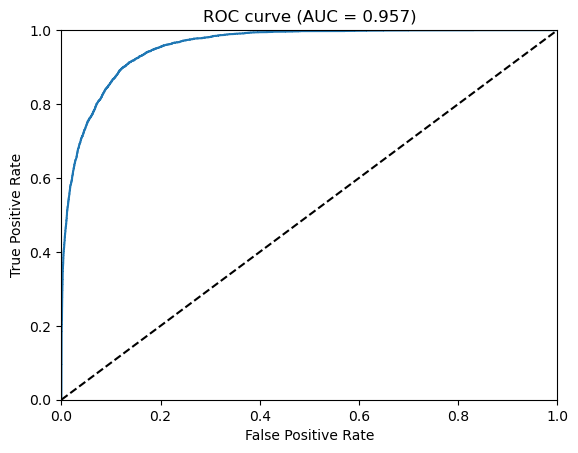

In [14]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX, testY)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [15]:
tprthreshindex = np.where(tpr >=0.9)[0][0]
falsePos = fpr[tprthreshindex]
print(f"AUC: {roc_auc} \nFPR: {falsePos}")

AUC: 0.9567219283014167 
FPR: 0.1254607413589262


# Feature importance

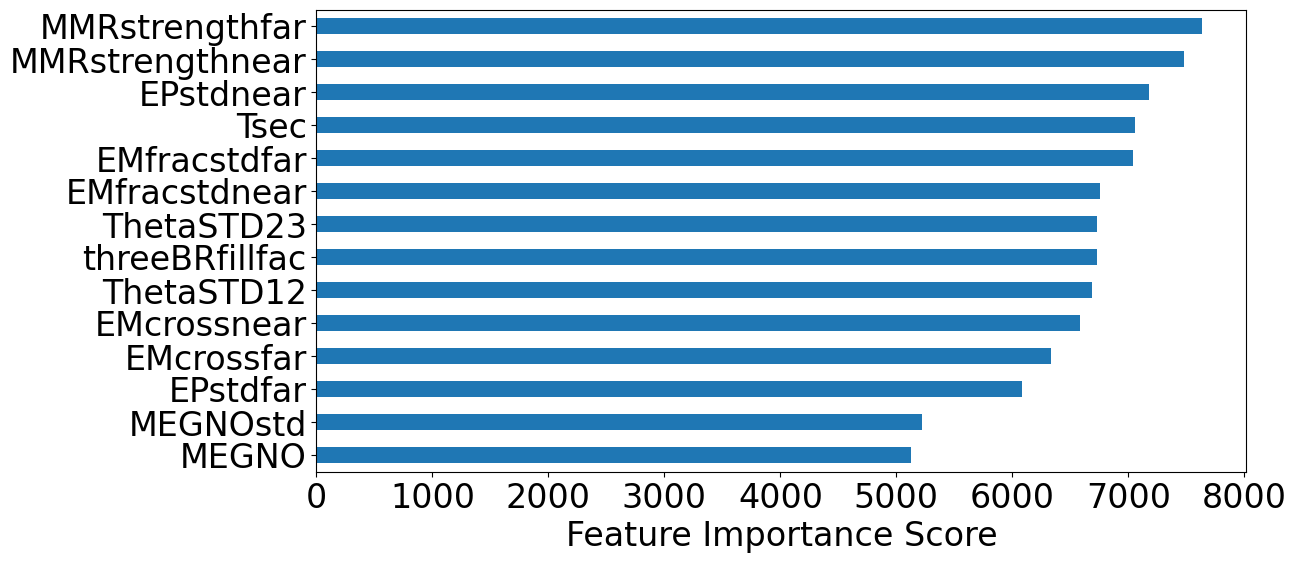

In [16]:
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,6), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()

# Performance histogram

(0.0, 561.0)

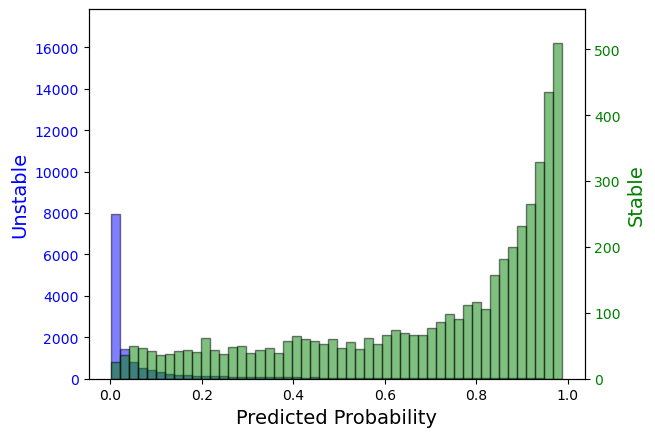

In [24]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(model, testX, testY)

fig, ax1 = plt.subplots()
n, bins, patches = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    
ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
       
ax1.set_ylim([0,35*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

# Model performance and accuracy

Text(0, 0.5, 'Fraction actually stable')

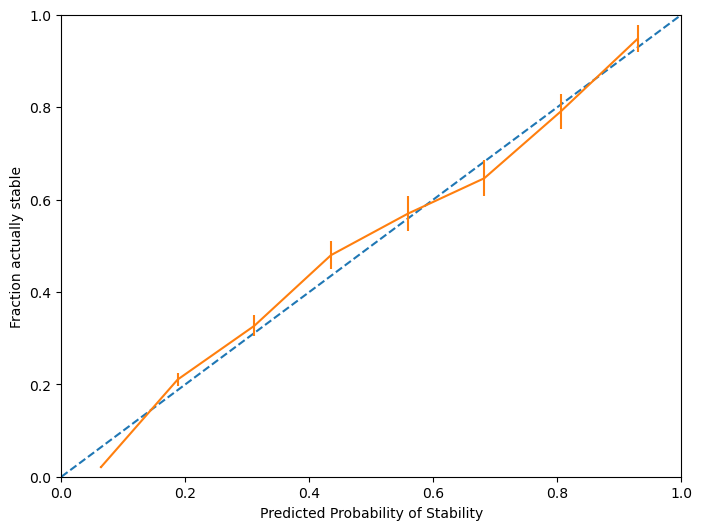

In [25]:
bincenters, fracstable, errorbars = calibration_plot(model, testX, testY, bins=8)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')